# Extract features from AudioSet for training

## Load and filter classes
The first thing we need to do is to select the sounds we're going to identify from the labels indexes csv file

In [1]:
import pandas as pd
import pickle

classes_file = "../dataset/class_labels_indices.csv"
selected_classes = ["Vehicle horn, car horn, honking", "Children playing", "Dog", "Jackhammer", "Siren", 
                    "Traffic noise, roadway noise", "Subway, metro, underground", "Walk, footsteps", "Chatter", "Bird"]
df = pd.read_csv(classes_file)
df.set_index("index", inplace=True)
selected_classes_indexes = df.index[df['display_name'].isin(selected_classes)].tolist()

# Create dictionary with our classes
selected_classes_dict = {}
for i in selected_classes_indexes:
    selected_classes_dict[i] = df.iloc[i]['display_name']

print(selected_classes_dict)
# Save for later use
base_dir = "./features/"
dump_filename = f"{base_dir}classes_dict.pkl"

with open(dump_filename, "wb") as dump_file:
    pickle.dump(selected_classes_dict, dump_file)

{53: 'Walk, footsteps', 68: 'Chatter', 71: 'Children playing', 74: 'Dog', 111: 'Bird', 308: 'Vehicle horn, car horn, honking', 327: 'Traffic noise, roadway noise', 334: 'Subway, metro, underground', 396: 'Siren', 420: 'Jackhammer'}


### Create an encoder for our labels

In [2]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit([selected_classes_indexes])
print(list(mlb.classes_))

# Save mlb for our project
base_dir = "./features/"

dump_filename = f"{base_dir}multiLabelBinarizer.pkl"
with open(dump_filename, "wb") as dump_file:
    pickle.dump(mlb, dump_file)

[53, 68, 71, 74, 111, 308, 327, 334, 396, 420]


## Extract features from dataset
Now, we need to build a function to extract features from Google Audioset, which are formatted in tensorflow

In [3]:
import os
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

def extract_features(dataset_dir, mlb):
    X = []
    y = []
    recordset = os.listdir(dataset_dir)
    for record in recordset:
        raw_dataset = tf.data.TFRecordDataset(dataset_dir+record)    
        for raw_record in raw_dataset.take(-1):
            example = tf.train.Example()
            example.ParseFromString(raw_record.numpy())

            labels = example.features.feature['labels'].int64_list.value
            #print(f"Labels {labels}")

            for label in labels:
                if label in selected_classes_indexes:
                    video = example.features.feature['video_id'].bytes_list.value[0].decode("utf-8")
                    start = example.features.feature['start_time_seconds'].float_list.value[0]
                    end = example.features.feature['end_time_seconds'].float_list.value[0]
                    #print(f"Video: {video}")
                    #print("Start time: ", start)
                    #print(f"Duration: {end-start} seconds")
                    
                    labels_detected = set(labels).intersection(set(selected_classes_indexes))
                    #print(f"Labels detected: ", labels_detected)
                    
                    example_seq = tf.train.SequenceExample()
                    example_seq.ParseFromString(raw_record.numpy())
                    
                    try:
                        feats_list = example_seq.feature_lists.feature_list['audio_embedding']
                        X_temp = []
                        for i in range(10):
                            hex_features = feats_list.feature[i].bytes_list.value[0].hex()
                            features_array = [np.int32(int(hex_features[k:k+2],16)) for k in range(0,len(hex_features),2)]
                            # for l in labels_detected:
                                # If there's more than one of the selected labels in the video
                            X_temp.append(np.array(features_array))                        
                        X.append(np.array(X_temp))
                        y.append(list(labels_detected))
                    except IndexError as ie:
                            # It doesn't have 10 arrays, ignore
                            print(f"pass {record}, video {video}")
                            continue
    #print(X)
    X = np.asarray(X)
    y = np.array(y, dtype=object)
    
    # Apply OneHotEncodig to ground truth
    y = mlb.transform(y)

    # We need to add at least one dimension to our X   
    # X = X.reshape(X.shape[0], 128, 1)
    return X,y

### Extract training data

In [4]:
# Extract data for training
X_train, y_train = extract_features("../dataset/audioset_v1_embeddings/bal_train/", mlb)

print(X_train.shape, y_train.shape)

pass aL.tfrecord, video aLnpHdhIqWE
pass e7.tfrecord, video e78QzuLkfkY
pass fW.tfrecord, video fWBzCRl6LUs
pass SS.tfrecord, video SS3jkEZXws0
pass Tm.tfrecord, video Tm_iwnX6hn0
pass WC.tfrecord, video WCFt-dggFlk
pass WF.tfrecord, video WF6QmF1ZG9o
(1065, 10, 128) (1065, 10)


#### Check balance

<AxesSubplot:xlabel='0'>

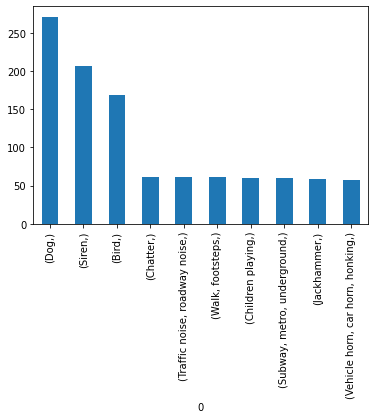

In [5]:
sounds = [selected_classes_dict.get(mlb.classes_[y.argmax()]) for y in y_train]
df = pd.DataFrame(sounds)
df.value_counts().plot.bar()

### Extract evaluation data

In [6]:
# Extract also X and y for validation
X_val, y_val = extract_features("../dataset/audioset_v1_embeddings/eval/", mlb)
print(X_val.shape, y_val.shape)

pass -0.tfrecord, video -0CamVQdP_Y
pass -8.tfrecord, video -8pCMgGKZY8
pass 0f.tfrecord, video 0foC-4n-eH0
pass 3T.tfrecord, video 3TyBFLPxDw8
pass 8T.tfrecord, video 8TWtLCjUI5I
pass 9N.tfrecord, video 9NPKQDaNCRk
pass Am.tfrecord, video AmhjSlnn8dc
pass cX.tfrecord, video cXpawpxoSq0
pass fP.tfrecord, video fPFpRsKbzfU
pass hv.tfrecord, video hvjGvi7geEU
pass m1.tfrecord, video m1e9aOwRiDQ
pass N0.tfrecord, video N0jVgldCwAk
pass n6.tfrecord, video n6SvDBZaCUQ
pass NO.tfrecord, video NOZsDTFLm7M
pass nR.tfrecord, video nRZ4Vi-4qMQ
pass Ps.tfrecord, video PsZQ3cKwQNM
pass Sb.tfrecord, video Sb0169-lqLs
(1062, 10, 128) (1062, 10)


#### Check balance

<AxesSubplot:xlabel='0'>

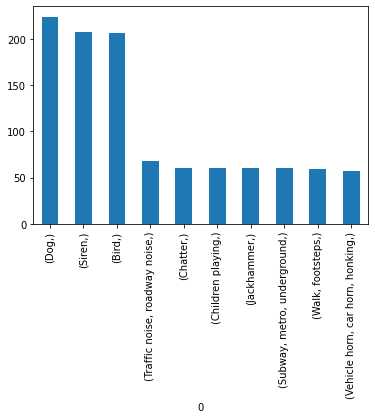

In [7]:
sounds = [selected_classes_dict.get(mlb.classes_[y.argmax()]) for y in y_val]
df = pd.DataFrame(sounds)
df.value_counts().plot.bar()

### Extract unbalanced data

In [8]:
# Extract also X and y from unbalanced data
X_unbal, y_unbal = extract_features("../dataset/audioset_v1_embeddings/unbal_train/", mlb)
print(X_unbal.shape, y_unbal.shape)

pass -1.tfrecord, video -1LrSyhL6Zs
pass -1.tfrecord, video -1SKsJayTP4
pass -2.tfrecord, video -2ni2KI5S5A
pass -4.tfrecord, video -4oBn8qurR4
pass -9.tfrecord, video -9v9vrARusA
pass -9.tfrecord, video -9gdBXU1um4
pass -9.tfrecord, video -9P1IlNEgsM
pass -C.tfrecord, video -CFQ6V1PAhA
pass -D.tfrecord, video -D9V9oIZm_A
pass -D.tfrecord, video -DsCcOSF_-c
pass -d.tfrecord, video -dyC8nm8MqI
pass -d.tfrecord, video -dcQcVD2gsk
pass -e.tfrecord, video -eiz-vShnpQ
pass -F.tfrecord, video -FL9SIdEWMo
pass -f.tfrecord, video -f_XPuqYXZU
pass -f.tfrecord, video -fGFQTGd2nA
pass -g.tfrecord, video -gdUN7I2-w4
pass -H.tfrecord, video -HnhPxiYLLU
pass -j.tfrecord, video -j6b3MMs7FI
pass -j.tfrecord, video -jICNm6Iim8
pass -M.tfrecord, video -MobtxIiE20
pass -m.tfrecord, video -mwAgcK86g8
pass -O.tfrecord, video -OSQgvBIQc4
pass -o.tfrecord, video -o_PQtWJCww
pass -R.tfrecord, video -RRMorr6ljI
pass -r.tfrecord, video -rjFEuMUTQQ
pass -t.tfrecord, video -tIExGIwFKg
pass -U.tfrecord, video -UvF

pass 5R.tfrecord, video 5RhmPMwy344
pass 5R.tfrecord, video 5RFOKyfbzvA
pass 5r.tfrecord, video 5rj1UliXhnU
pass 5t.tfrecord, video 5ttsSgm21vo
pass 5W.tfrecord, video 5WIfUDC8f6k
pass 5_.tfrecord, video 5_uTvbEuzqw
pass 62.tfrecord, video 626QX3tukLQ
pass 64.tfrecord, video 64JQ8uvvGMs
pass 64.tfrecord, video 64ZHAQKSHy4
pass 65.tfrecord, video 655gsRnE6Ms
pass 67.tfrecord, video 67DN2RcsGzg
pass 69.tfrecord, video 698uQHTmW3g
pass 6a.tfrecord, video 6aB4aWbg2oU
pass 6B.tfrecord, video 6BtP6mjG1W4
pass 6b.tfrecord, video 6bpCdKeGKDk
pass 6C.tfrecord, video 6CsF2quo-7U
pass 6c.tfrecord, video 6cZmTDAxCLA
pass 6c.tfrecord, video 6ceVl10U3II
pass 6e.tfrecord, video 6eRUgESs3JM
pass 6f.tfrecord, video 6f50Yt9VJNY
pass 6G.tfrecord, video 6GZg9Z446u0
pass 6g.tfrecord, video 6g7bEueapOM
pass 6I.tfrecord, video 6Imfbv3BAtc
pass 6j.tfrecord, video 6jdyueVKa9M
pass 6l.tfrecord, video 6lZzZusf_jg
pass 6O.tfrecord, video 6Op9x_xp8Xo
pass 6p.tfrecord, video 6pucgE9AGDk
pass 6Q.tfrecord, video 6Q9m

pass Cg.tfrecord, video CgeUYRtoEiw
pass Cg.tfrecord, video CgA4qDFtmcs
pass cG.tfrecord, video cG6gBwkNeFw
pass ch.tfrecord, video chzhxl_2KOc
pass CJ.tfrecord, video CJ0QfTRSG3I
pass Cj.tfrecord, video Cj4wRjzSvGw
pass cj.tfrecord, video cjBnpZ7RtNM
pass ck.tfrecord, video ckPUaLHjnQk
pass cL.tfrecord, video cLZqpi4FwfY
pass cl.tfrecord, video clHIj2xKkyA
pass cm.tfrecord, video cmV_2UC8Gdw
pass cn.tfrecord, video cnNeEPdJrRw
pass co.tfrecord, video coT09SF2f44
pass CP.tfrecord, video CP77gjXBbvQ
pass CP.tfrecord, video CP_bvdC2Yg4
pass cs.tfrecord, video csQf0huI3nk
pass cs.tfrecord, video csNY1LAFRAI
pass cT.tfrecord, video cTe3MOLdVec
pass cU.tfrecord, video cUC-1xK5za4
pass Cv.tfrecord, video Cv8GA3mcmUA
pass Cv.tfrecord, video CvNzcXAwGzQ
pass cv.tfrecord, video cvzXT-4c1Gc
pass CW.tfrecord, video CWYMuzMPv4Q
pass CX.tfrecord, video CXAqQlWK9NM
pass cX.tfrecord, video cXQKP-HYzZE
pass cX.tfrecord, video cX6fnwueXpo
pass cx.tfrecord, video cxGNTDlNNqQ
pass cY.tfrecord, video cYyj

pass HK.tfrecord, video HKAbjsiKIyM
pass HL.tfrecord, video HLY9kdv7hGk
pass HN.tfrecord, video HNFpbzWrKWA
pass HN.tfrecord, video HNM-5V0tFRo
pass hn.tfrecord, video hnmWvk9TLlY
pass hn.tfrecord, video hnF6sSxme4o
pass hO.tfrecord, video hO71Lk2CFd4
pass HR.tfrecord, video HRMjoURjI9k
pass Hr.tfrecord, video HrAwwiLkR0I
pass Hs.tfrecord, video HsQ_JVZNps0
pass HT.tfrecord, video HTu9ueFdjF4
pass Ht.tfrecord, video HtlXqeYBpH4
pass ht.tfrecord, video htoBwwTaV0g
pass HU.tfrecord, video HUzcgHvGwxs
pass Hu.tfrecord, video Hudx2oL6WJ4
pass Hw.tfrecord, video Hw9LaG6CQrM
pass Hx.tfrecord, video HxGZxfu3uGM
pass Hx.tfrecord, video Hx64JDUwZ6E
pass Hx.tfrecord, video Hx6BT4gCe8M
pass I-.tfrecord, video I-sVagwYgIo
pass i-.tfrecord, video i-FFv6VSQRk
pass I0.tfrecord, video I0rvueKAsZo
pass I1.tfrecord, video I1Nq6yl5Ty4
pass i1.tfrecord, video i1uI2VR5Q_I
pass i3.tfrecord, video i3__c2SwrEs
pass i3.tfrecord, video i3uUjJHj_Oo
pass i4.tfrecord, video i4fuY8OZfUw
pass i4.tfrecord, video i4zY

pass mp.tfrecord, video mpc5aKhgJyc
pass MQ.tfrecord, video MQVO5C9-AFM
pass mr.tfrecord, video mrTVzbN72pY
pass MS.tfrecord, video MSPcsRXT2_k
pass mS.tfrecord, video mS8JRJIyse8
pass mT.tfrecord, video mTqlvdogpVQ
pass Mu.tfrecord, video MuVzGuUQoBg
pass mU.tfrecord, video mUoMW0I-2v8
pass mU.tfrecord, video mUKJUk9ipdQ
pass mV.tfrecord, video mVEI2UME1KI
pass MW.tfrecord, video MWSfaYUDDZI
pass mw.tfrecord, video mwOuitEsj7Q
pass my.tfrecord, video my7W6eXU7rc
pass MZ.tfrecord, video MZ4izj2OJ7Y
pass MZ.tfrecord, video MZFnCug8ALw
pass mz.tfrecord, video mzf92KBJpf8
pass n-.tfrecord, video n-7XOOIcIVM
pass N3.tfrecord, video N3U90ESlllI
pass N4.tfrecord, video N4Pb0qr95G4
pass n5.tfrecord, video n5O4f0BdeKs
pass n5.tfrecord, video n5oi5xRATPY
pass N7.tfrecord, video N788XJLnkXM
pass N7.tfrecord, video N7lqqW9k3vE
pass n7.tfrecord, video n7MvOIf99yo
pass N8.tfrecord, video N8ODwPWak3Y
pass N9.tfrecord, video N9nMs3aw9j0
pass n9.tfrecord, video n9QYEwOpmck
pass Na.tfrecord, video Naq1

pass RV.tfrecord, video RVI8g3Zs_U4
pass Rv.tfrecord, video RvYdMmB5Rxo
pass Rv.tfrecord, video RvpHzYQqbe8
pass rV.tfrecord, video rVekwFw6oUo
pass rW.tfrecord, video rW6RsF4YvLk
pass RX.tfrecord, video RXXJvrRb2xw
pass RY.tfrecord, video RYITEmE6ySM
pass RZ.tfrecord, video RZ_Hwxoh2iE
pass RZ.tfrecord, video RZB2b4WE5kA
pass Rz.tfrecord, video RzUwE_hPskg
pass rZ.tfrecord, video rZqgDMnAFCY
pass r_.tfrecord, video r_9SalJgqp8
pass S-.tfrecord, video S-TtdYf0tgI
pass S1.tfrecord, video S1wUn1aYZeA
pass S1.tfrecord, video S1iY52aDj04
pass s1.tfrecord, video s1b0cuRL2M0
pass S3.tfrecord, video S3dm8a_21F0
pass s3.tfrecord, video s3NF9VW3o9Q
pass S4.tfrecord, video S4aKOyRaImE
pass S5.tfrecord, video S54Ev5cbczs
pass S5.tfrecord, video S5LouUJTwcU
pass s5.tfrecord, video s5Vsp7HwIbE
pass S6.tfrecord, video S6fzfTXig48
pass S7.tfrecord, video S7pUZdKhcL8
pass S8.tfrecord, video S8jjFTDP_s4
pass s9.tfrecord, video s9jC78csVVQ
pass s9.tfrecord, video s92LEO6kqrU
pass Sc.tfrecord, video ScFx

pass wX.tfrecord, video wXxMKFDPkh0
pass wx.tfrecord, video wxSYPERswK8
pass wy.tfrecord, video wyZRP0VFCRI
pass Wz.tfrecord, video WzL93_ieZ3E
pass XA.tfrecord, video XAm7HafF2EA
pass Xa.tfrecord, video Xa8xgzVURUM
pass Xa.tfrecord, video XaAuoc58bkY
pass xB.tfrecord, video xBwap76g-L0
pass xb.tfrecord, video xb-5EDJ1NmA
pass XC.tfrecord, video XCX0Hyn1GJM
pass xc.tfrecord, video xcolv9go3CU
pass Xd.tfrecord, video Xd1lT6QbbO4
pass xd.tfrecord, video xdZWm1Pur94
pass xd.tfrecord, video xdZNPaHp-PA
pass XE.tfrecord, video XE3zI6nEh68
pass xE.tfrecord, video xEtJYPrUoIk
pass xe.tfrecord, video xeYkhYXqaSQ
pass XF.tfrecord, video XF5_tB6V9HE
pass xF.tfrecord, video xFFaYARr7t8
pass XG.tfrecord, video XGRoHNp0pTc
pass xg.tfrecord, video xgLa7vBCs_M
pass Xh.tfrecord, video Xhf_CwHfbmE
pass xh.tfrecord, video xhI_rZC2bs4
pass Xi.tfrecord, video Xi56bRQ5FOI
pass xK.tfrecord, video xKs2NRVjAJg
pass XL.tfrecord, video XLpl3CgynQg
pass xM.tfrecord, video xMnUzw0yrJw
pass xN.tfrecord, video xNH_

<AxesSubplot:xlabel='0'>

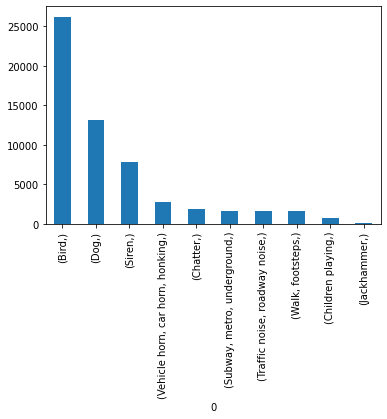

In [9]:
sounds = [selected_classes_dict.get(mlb.classes_[y.argmax()]) for y in y_unbal]
df = pd.DataFrame(sounds)
df.value_counts().plot.bar()

### Save results for later

In [11]:
from pathlib import Path

# Save training and evaluation sets
Path(base_dir).mkdir(exist_ok=True)   

dump_filename = f"{base_dir}X_train.pkl"
with open(dump_filename, "wb") as dump_file:
    pickle.dump(X_train, dump_file)
    
dump_filename = f"{base_dir}y_train.pkl"
with open(dump_filename, "wb") as dump_file:
    pickle.dump(y_train, dump_file)
    
dump_filename = f"{base_dir}X_val.pkl"
with open(dump_filename, "wb") as dump_file:
    pickle.dump(X_val, dump_file)
    
dump_filename = f"{base_dir}y_val.pkl"
with open(dump_filename, "wb") as dump_file:
    pickle.dump(y_val, dump_file)
    
dump_filename = f"{base_dir}X_unbal.pkl"
with open(dump_filename, "wb") as dump_file:
    pickle.dump(X_unbal, dump_file)
    
dump_filename = f"{base_dir}y_unbal.pkl"
with open(dump_filename, "wb") as dump_file:
    pickle.dump(y_unbal, dump_file)